In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
db_name = os.getenv("db_name")
db_user = os.getenv("db_user")
db_password = os.getenv("db_password")
db_host = os.getenv("db_host")

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_name}')

query = "SELECT * FROM StockPrice;"

df = pd.read_sql(query, engine)

In [3]:
df = df.set_index("date", drop=True)
df.head()

,ticker,open,high,low,close,volume,dividends,splits
date,,,,,,,,
2019-09-24,UBSG.SW,8.69,8.78,8.59,8.65,20579894,0.0,0.0
2019-09-25,UBSG.SW,8.57,8.61,8.40,8.58,16567767,0.0,0.0
2019-09-26,UBSG.SW,8.58,8.66,8.53,8.63,10379192,0.0,0.0
2019-09-27,UBSG.SW,8.67,8.75,8.63,8.71,15560578,0.0,0.0
2019-09-30,UBSG.SW,8.64,8.83,8.64,8.76,14544063,0.0,0.0


In [4]:
df_ts = df.pivot_table(values='close', index=df.index, columns='ticker')[:-1]
df_ts = df_ts.ffill()
df_ts

ticker,AAPL,AMZN,KO,META,MSFT,NVDA,PFE,TSLA,UBS,UBSG.SW,XOM
date,,,,,,,,,,,
2019-09-24,52.66,87.08,46.51,180.74,131.22,4.29,27.74,14.88,9.53,8.65,55.61
2019-09-25,53.47,88.42,46.40,182.25,133.11,4.43,27.66,15.25,9.53,8.58,55.77
2019-09-26,53.19,86.99,46.59,179.57,133.28,4.41,27.56,16.17,9.51,8.63,55.47
2019-09-27,52.93,86.27,46.52,176.57,131.55,4.27,27.90,16.14,9.60,8.71,55.87
2019-09-30,54.18,86.80,46.63,177.55,132.79,4.33,27.68,16.06,9.59,8.76,55.19
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-17,216.79,186.88,71.80,536.32,435.15,115.59,29.83,227.87,29.76,25.34,114.18
2024-09-18,220.69,186.43,71.75,537.95,430.81,113.37,29.75,227.20,29.91,25.28,114.58
2024-09-19,228.87,189.87,70.62,559.10,438.69,117.87,29.66,243.92,30.40,25.65,116.00


In [5]:
df_log_returns = df_ts[["UBS", "AAPL", "PFE", "AMZN", "META", "TSLA", "NVDA", "XOM", "MSFT", "KO"]]
df_log_returns = np.log1p(df_log_returns.pct_change()) * 100
df_log_returns

ticker,UBS,AAPL,PFE,AMZN,META,TSLA,NVDA,XOM,MSFT,KO
date,,,,,,,,,,
2019-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-25,0.000000,1.526459,-0.288809,1.527095,0.831984,2.456147,3.211285,0.287305,1.430055,-0.236788
2019-09-26,-0.210084,-0.525034,-0.362188,-1.630502,-1.481427,5.857817,-0.452489,-0.539376,0.127632,0.408647
2019-09-27,0.941922,-0.490012,1.226124,-0.831126,-1.684771,-0.185701,-3.226086,0.718523,-1.306517,-0.150360
2019-09-30,-0.104221,2.334155,-0.791656,0.612471,0.553486,-0.496895,1.395371,-1.224579,0.938193,0.236178
...,...,...,...,...,...,...,...,...,...,...
2024-09-17,-0.100756,0.217035,-0.801340,1.070565,0.568438,0.479491,-1.024238,1.295800,0.879416,-0.416957
2024-09-18,0.502766,1.782986,-0.268547,-0.241087,0.303462,-0.294460,-1.939264,0.349712,-1.002364,-0.069662
2024-09-19,1.624974,3.639515,-0.302980,1.828379,3.856273,7.100962,3.892552,1.231692,1.812586,-1.587446


In [6]:
trading_days_per_year = 252
risk_free_rate = 0.00

In [7]:
annualized_mean_return = df_log_returns.mean() * trading_days_per_year
annualized_mean_return

ticker
UBS     22.561903
AAPL    28.518743
PFE      1.076295
AMZN    15.648089
META    22.262048
TSLA    55.159318
NVDA    64.506181
XOM     14.601593
MSFT    23.363070
KO       8.469893
dtype: float64

In [8]:
annualized_std = df_log_returns.std() * np.sqrt(trading_days_per_year)
annualized_std

ticker
UBS     33.893232
AAPL    31.310428
PFE     26.731538
AMZN    35.099632
META    44.718950
TSLA    64.962108
NVDA    52.649387
XOM     33.964596
MSFT    29.939172
KO      20.601163
dtype: float64

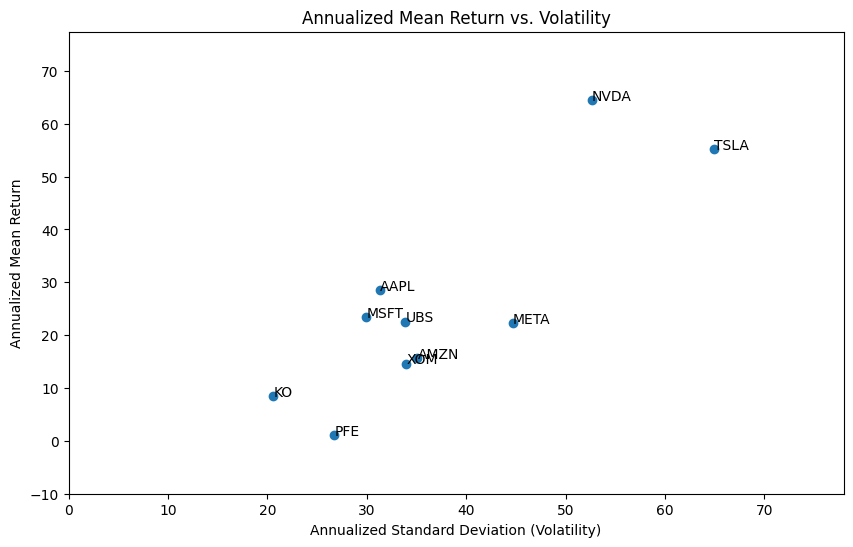

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(annualized_std, annualized_mean_return)

for ticker in annualized_std.index:
    plt.text(annualized_std[ticker], annualized_mean_return[ticker], ticker)

plt.xlabel('Annualized Standard Deviation (Volatility)')
plt.ylabel('Annualized Mean Return')
plt.title('Annualized Mean Return vs. Volatility')

plt.xlim(0, max(annualized_std) * 1.2)
plt.ylim(-10, max(annualized_mean_return) * 1.2)

plt.show()

In [10]:
df_log_returns.corr()

ticker,UBS,AAPL,PFE,AMZN,META,TSLA,NVDA,XOM,MSFT,KO
ticker,,,,,,,,,,
UBS,1.000000,0.458778,0.283698,0.355717,0.370233,0.322656,0.411208,0.495372,0.462766,0.439154
AAPL,0.458778,1.000000,0.287750,0.598547,0.559586,0.498944,0.619310,0.296338,0.751066,0.440486
PFE,0.283698,0.287750,1.000000,0.170562,0.188779,0.087021,0.155859,0.251589,0.320689,0.422883
AMZN,0.355717,0.598547,0.170562,1.000000,0.606185,0.435018,0.592697,0.145285,0.678723,0.228669
META,0.370233,0.559586,0.188779,0.606185,1.000000,0.334422,0.537270,0.161587,0.615805,0.222770
TSLA,0.322656,0.498944,0.087021,0.435018,0.334422,1.000000,0.487655,0.156131,0.460710,0.175110
NVDA,0.411208,0.619310,0.155859,0.592697,0.537270,0.487655,1.000000,0.193071,0.693992,0.224491
XOM,0.495372,0.296338,0.251589,0.145285,0.161587,0.156131,0.193071,1.000000,0.257313,0.427044
MSFT,0.462766,0.751066,0.320689,0.678723,0.615805,0.460710,0.693992,0.257313,1.000000,0.439523


In [11]:
cov_matrix = df_log_returns.cov() * trading_days_per_year
cov_matrix

ticker,UBS,AAPL,PFE,AMZN,META,TSLA,NVDA,XOM,MSFT,KO
ticker,,,,,,,,,,
UBS,1148.751146,486.860259,257.035792,423.175224,561.151482,710.415928,733.782500,570.257926,469.584805,306.634540
AAPL,486.860259,980.342874,240.839534,657.793498,783.515036,1014.846871,1020.917243,315.139866,704.055600,284.127167
PFE,257.035792,240.839534,714.575105,160.032303,225.667510,151.114537,219.356219,228.423813,256.653806,232.881808
AMZN,423.175224,657.793498,160.032303,1231.984160,951.479225,991.903465,1095.289408,173.200793,713.238569,165.349259
META,561.151482,783.515036,225.667510,951.479225,1999.784492,971.508283,1264.961842,245.428503,824.469133,205.229638
TSLA,710.415928,1014.846871,151.114537,991.903465,971.508283,4220.075449,1667.885222,344.488785,896.039564,234.348299
NVDA,733.782500,1020.917243,219.356219,1095.289408,1264.961842,1667.885222,2771.957911,345.252019,1093.924844,243.491896
XOM,570.257926,315.139866,228.423813,173.200793,245.428503,344.488785,345.252019,1153.593811,261.654053,298.807059
MSFT,469.584805,704.055600,256.653806,713.238569,824.469133,896.039564,1093.924844,261.654053,896.354009,271.089900


In [12]:
portfolio_returns = []
portfolio_volatilities = []

In [13]:
weights = np.linspace(0, 1, 20)

for w in weights:
    weight_array = np.array([w, 1 - w])
    portfolio_return = np.dot(weight_array, [annualized_mean_return['AAPL'], annualized_mean_return['UBS']])
    portfolio_volatility = np.sqrt(np.dot(weight_array.T, np.dot(cov_matrix.loc[['AAPL', 'UBS'], ['AAPL', 'UBS']], weight_array)))
    portfolio_returns.append(portfolio_return)
    portfolio_volatilities.append(portfolio_volatility)

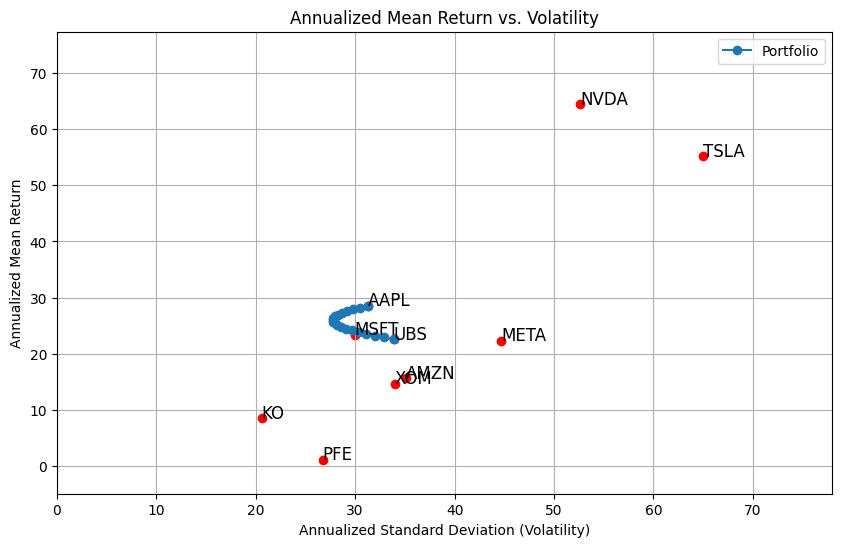

In [14]:
plt.figure(figsize=(10, 6))
# plt.plot(portfolio_volatilities, portfolio_returns, marker='o', label='Portfolio')

plt.scatter(annualized_std, annualized_mean_return, color='red')

for ticker in annualized_std.index:
    plt.text(annualized_std[ticker], annualized_mean_return[ticker], ticker, fontsize=12)

plt.xlabel('Annualized Standard Deviation (Volatility)')
plt.ylabel('Annualized Mean Return')
plt.title('Annualized Mean Return vs. Volatility')
plt.grid(True)

plt.xlim(0, max(annualized_std) * 1.2)
plt.ylim(-5, max(annualized_mean_return) * 1.2)

plt.legend()

plt.show()


In [15]:
# Gewichtungen definieren
num_portfolios = 500_000
num_assets = len(df_log_returns.columns)
results = np.zeros((3 + num_assets, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    portfolio_return = np.dot(weights, annualized_mean_return)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    results[0, i] = portfolio_volatility
    results[1, i] = portfolio_return
    results[2, i] = sharpe_ratio
    results[3:, i] = weights

In [16]:
min_volatility_idx = np.argmin(results[0])
min_volatility = results[0, min_volatility_idx]
min_volatility_return = results[1, min_volatility_idx]
min_volatility_weights = results[3:, min_volatility_idx]

max_sharpe_idx = np.argmax(results[2])
max_sharpe_ratio = results[2, max_sharpe_idx]
max_sharpe_volatility = results[0, max_sharpe_idx]
max_sharpe_return = results[1, max_sharpe_idx]
max_sharpe_weights = results[3:, max_sharpe_idx]

In [17]:
# Filtere Portfolios mit Gewichtungen <= 0.2
valid_portfolios = []
for i in range(num_portfolios):
    weights = results[3:, i]
    if all(weights <= 0.2):
        valid_portfolios.append(i)

max_sharpe_weights_idx = np.argmax(results[2, valid_portfolios])

# Extrahiere das Portfolio mit der maximalen Rendite
max_sharpe_weights_portfolio = valid_portfolios[max_sharpe_weights_idx]
max_return_weights = results[1, max_sharpe_weights_portfolio]
max_volatility_weights = results[0, max_sharpe_weights_portfolio]
max_weights_weights = results[3:, max_sharpe_weights_portfolio]

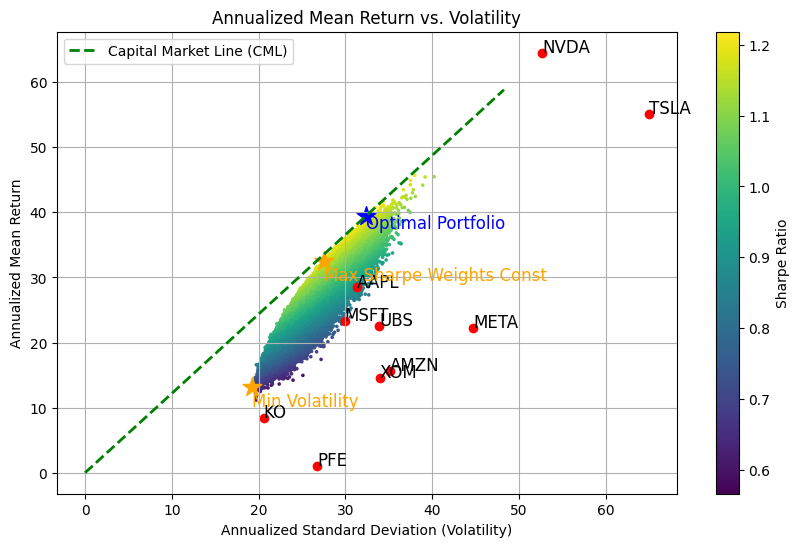

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='.', s=10)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(annualized_std, annualized_mean_return, color='red')

for ticker in annualized_std.index:
    plt.text(annualized_std[ticker], annualized_mean_return[ticker], ticker, fontsize=12)

plt.scatter(max_sharpe_volatility, max_sharpe_return, color='blue', marker='*', s=200)
plt.text(max_sharpe_volatility, max_sharpe_return -2, 'Optimal Portfolio', fontsize=12, color='blue')


plt.scatter(min_volatility, min_volatility_return, color='orange', marker='*', s=200)
plt.text(min_volatility, min_volatility_return - 3, 'Min Volatility', fontsize=12, color='orange')

plt.scatter(max_volatility_weights, max_return_weights, color='orange', marker='*', s=200)
plt.text(max_volatility_weights, max_return_weights - 3, 'Max Sharpe Weights Const', fontsize=12, color='orange')

cml_x = np.linspace(0, max(results[0]) * 1.2, 100)
cml_y = risk_free_rate + max_sharpe_ratio * cml_x
plt.plot(cml_x, cml_y, color='green', linestyle='--', linewidth=2, label='Capital Market Line (CML)')

plt.xlabel('Annualized Standard Deviation (Volatility)')
plt.ylabel('Annualized Mean Return')
plt.title('Annualized Mean Return vs. Volatility')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
print(f"\nPortfolio mit der geringsten Volatilität:")
print(f"Volatilität: {min_volatility:.4f}")
print(f"Rendite: {min_volatility_return:.4f}")
print(f"Gewichtungen:")
for ticker, weight in zip(df_log_returns.columns, min_volatility_weights):
    print(f"{ticker}: {weight:.4f}")


Portfolio mit der geringsten Volatilität:
Volatilität: 19.2387
Rendite: 13.1804
Gewichtungen:
UBS: 0.0114
AAPL: 0.0578
PFE: 0.2434
AMZN: 0.1297
META: 0.0255
TSLA: 0.0154
NVDA: 0.0213
XOM: 0.1201
MSFT: 0.0844
KO: 0.2908


In [20]:
print(f"Optimal Portfolio (Highest Sharpe Ratio):")
print(f"Sharpe Ratio: {max_sharpe_ratio:.4f}")
print(f"Volatilität: {max_sharpe_volatility:.4f}")
print(f"Rendite: {max_sharpe_return:.4f}")
print(f"Gewichtungen:")
for ticker, weight in zip(df_log_returns.columns, max_sharpe_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Portfolio (Highest Sharpe Ratio):
Sharpe Ratio: 1.2182
Volatilität: 32.4275
Rendite: 39.5034
Gewichtungen:
UBS: 0.1650
AAPL: 0.2029
PFE: 0.0483
AMZN: 0.0290
META: 0.0012
TSLA: 0.1323
NVDA: 0.3159
XOM: 0.0555
MSFT: 0.0372
KO: 0.0127


In [22]:
# Filtere Portfolios mit Gewichtungen <= 0.2
valid_portfolios = []
for i in range(num_portfolios):
    weights = results[3:, i]
    if all(weights <= 0.2):
        valid_portfolios.append(i)

# Finde das Portfolio mit der maximalen Rendite
max_return_idx = np.argmax(results[1, valid_portfolios])

# Extrahiere das Portfolio mit der maximalen Rendite
max_return_portfolio = valid_portfolios[max_return_idx]
max_return = results[1, max_return_portfolio]
max_volatility = results[0, max_return_portfolio]
max_weights = results[3:, max_return_portfolio]

# Ergebnis anzeigen
print(f"\nPortfolio mit der maximalen Sharpe Ratio und Gewichtungen <= 0.2:")
print(f"Rendite: {max_return:.4f}")
print(f"Volatilität: {max_volatility:.4f}")
print(f"Gewichtungen:")
for ticker, weight in zip(df_log_returns.columns, max_weights):
    print(f"{ticker}: {weight:.4f}")


Portfolio mit der maximalen Sharpe Ratio und Gewichtungen <= 0.2:
Rendite: 36.9915
Volatilität: 33.2773
Gewichtungen:
UBS: 0.1333
AAPL: 0.1590
PFE: 0.0005
AMZN: 0.0523
META: 0.1593
TSLA: 0.1818
NVDA: 0.1965
XOM: 0.0036
MSFT: 0.0920
KO: 0.0218
